2.8.0
GPU Available: False
cpu:0
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 100)               2000      
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_95 (Dense)            (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 100)               78500     
                                                           

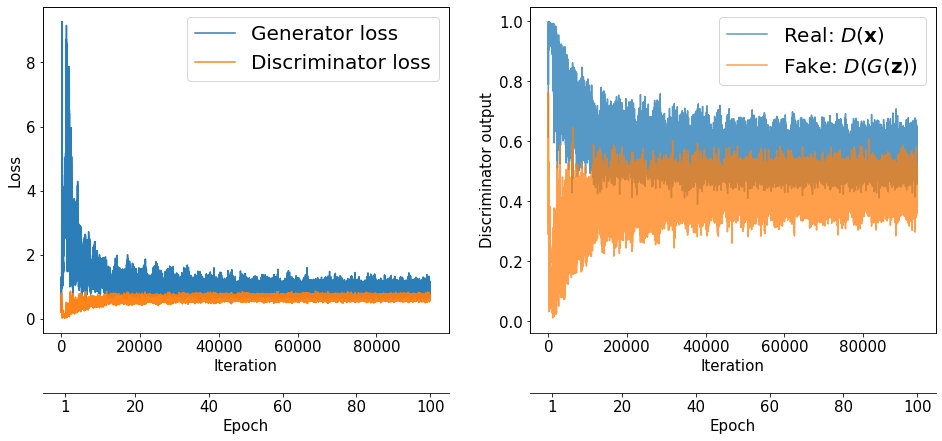

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt


print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'cpu:0'
    
print(device_name)

#drive.mount('/content/drive/')

def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, 
                use_bias=False)
            )
        model.add(tf.keras.layers.LeakyReLU())
        
    model.add(tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model

def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
    model.add(
        tf.keras.layers.Dense(
            units=num_output_units, 
            activation=None)
        )
    return model




image_size = (28, 28)
z_size = 20
mode_z = 'uniform'  # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers, 
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

mnist_trainset=mnist['train']
mnist_trainset=mnist_trainset.map(preprocess)

mnist_trainset=mnist_trainset.batch(32,drop_remainder=True)
input_z,input_real=next(iter(mnist_trainset))
print('input-z -- shape: ',input_z.shape)
print('input_real -- shape:', input_real.shape)

g_output=gen_model(input_z)
print('Output of G -- shape:',g_output.shape)

d_logits_real=disc_model(input_real)
d_logits_fake=disc_model(g_output)
print('Disc. (real) -- shape:',d_logits_real.shape)
print('Disc. (fake) -- shape:',d_logits_fake.shape)

loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
##生成器ネットワークの損失関数
g_labels_real=tf.ones_like(d_logits_fake)
g_loss=loss_fn(y_true=g_labels_real,y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

##識別子ネットワークの損失関数
d_labels_real=tf.ones_like(d_logits_real)
d_labels_fake=tf.zeros_like(d_logits_fake)
d_loss_real=loss_fn(y_true=d_labels_real,y_pred=d_logits_real)
d_loss_fake=loss_fn(y_true=d_logits_fake,y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(),
                                                             d_loss_fake.numpy()))
num_epochs=100
batch_size=64
image_size=(28,28)
z_size=20
mode_z='uniform'
gen_hidden_layers=1
gen_hidden_size=100
disc_hidden_layers=1
disc_hidden_size=100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z=='uniform':
  fixed_z=tf.random.uniform(shape=(batch_size,z_size),minval=-1,maxval=1)
elif mode_z=='normal':
  fixed_z=tf.random.normal(shape=(batch_size,z_size))

def create_samples(gen_model,input_z):
  g_output=gen_model(input_z,training=False)
  images=tf.reshape(g_output,(batch_size,*image_size))
  return (images+1)/2.0

##データセットの準備
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()


